In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from utils.PreProcessing import compute_rul, remove_outliers
import scipy.stats as stats
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from BatteryDataToolkit import DataInitializer


/Users/ellamousavi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Loading Oxford Dataset

In [2]:
file_path = './Datasets/Oxford/Oxford_Battery_Degradation_Dataset_1.mat'
Conditions = range(1,9)
data_loader = DataInitializer(cutoff=0.1, fs=5, order=2, window_size=30)
data_dict = {Condition: data_loader.load_oxford(file_path = file_path, cell_number = Condition) for Condition in Conditions}

# Plot Single Cell Data Example : Cell2 = data_loader.load_oxford(file_path = file_path, cell_number = 2)

C0 = data_dict[1]['ch_cap'][0]
print(f'Initial Capacity {C0}')

Cell #1 Data successfully loaded from: ./Datasets/Oxford/Oxford_Battery_Degradation_Dataset_1.mat
Cell #2 Data successfully loaded from: ./Datasets/Oxford/Oxford_Battery_Degradation_Dataset_1.mat
Cell #3 Data successfully loaded from: ./Datasets/Oxford/Oxford_Battery_Degradation_Dataset_1.mat
Cell #4 Data successfully loaded from: ./Datasets/Oxford/Oxford_Battery_Degradation_Dataset_1.mat
Cell #5 Data successfully loaded from: ./Datasets/Oxford/Oxford_Battery_Degradation_Dataset_1.mat
Cell #6 Data successfully loaded from: ./Datasets/Oxford/Oxford_Battery_Degradation_Dataset_1.mat
Cell #7 Data successfully loaded from: ./Datasets/Oxford/Oxford_Battery_Degradation_Dataset_1.mat
Cell #8 Data successfully loaded from: ./Datasets/Oxford/Oxford_Battery_Degradation_Dataset_1.mat
Initial Capacity 724.1208914093187


In [4]:
train_conditions = [1,3,7,8]

num_paths = len(train_conditions)
ch_dch = 'ch' # or 'dch'

# Initialize lists to store aggregated data from all conditions
Cycle_list, Capacity_list, RUL_list, Temp_list, Volt_list = [], [], [], [], []

agg_HIs_ch = {}
agg_HIs_dch = {}

# Loop through each battery/condition
for cond in train_conditions:
    cell_data = data_dict[cond]

    # Select charge or discharge data based on the 'ch_dch' flag
    if ch_dch == 'dch':
        Capacity = cell_data['dch_cap']
        Cycle = cell_data['cycles']
        Temp = cell_data['Equalized_dch']['temperature']
        Volt = cell_data['Equalized_dch']['voltage']
    else:
        Capacity = cell_data['ch_cap']
        Cycle = cell_data['cycles']
        Temp = cell_data['Equalized_ch']['temperature']
        Volt = cell_data['Equalized_ch']['voltage']   

    # Process Discharge HIs
    for hi_name, hi_data in cell_data['HIs_dch'].items():
        if hi_name not in agg_HIs_dch:
            agg_HIs_dch[hi_name] = []
        agg_HIs_dch[hi_name].append(hi_data)
    
    # Process Charge HIs
    for hi_name, hi_data in cell_data['HIs_ch'].items():
        if hi_name not in agg_HIs_ch:
            agg_HIs_ch[hi_name] = []
        agg_HIs_ch[hi_name].append(hi_data)

    RUL = compute_rul(Capacity, Cycle, threshold=0.7*C0)
    RUL_list.append(RUL)
    Cycle_list.append(Cycle)
    Capacity_list.append(Capacity)
    Temp_list.append(Temp)
    Volt_list.append(Volt)


# Stack all paths
Cycles = [cycle for battery in Cycle_list for cycle in battery]
Capacities = [cycle for battery in Capacity_list for cycle in battery]
RULs = [cycle for battery in RUL_list for cycle in battery]

Temps = [cycle for battery in Temp_list for cycle in battery]
Volts = [cycle for battery in Volt_list for cycle in battery]

HIs_ch = {}
HIs_dch = {}

for hi_name, list_of_lists in agg_HIs_ch.items():
    HIs_ch[hi_name] = [item for sublist in list_of_lists for item in sublist]

for hi_name, list_of_lists in agg_HIs_dch.items():
    HIs_dch[hi_name] = [item for sublist in list_of_lists for item in sublist]


# Convert to tensor
Cycles = tf.convert_to_tensor(Cycles, dtype=tf.float32)
Capacities = tf.convert_to_tensor(Capacities, dtype=tf.float32)
RULs = tf.convert_to_tensor(RULs, dtype=tf.float32)

Temps = pad_sequences(Temps, dtype='float32', padding='post')
Volts = pad_sequences(Volts, dtype='float32', padding='post')

Temps = tf.convert_to_tensor(Temps, dtype=tf.float32)
Volts = tf.convert_to_tensor(Volts, dtype=tf.float32)

for hi_name, hi_data in HIs_ch.items():
    HIs_ch[hi_name] = tf.convert_to_tensor(hi_data, dtype=tf.float32)

for hi_name, hi_data in HIs_dch.items():
    HIs_dch[hi_name] = tf.convert_to_tensor(hi_data, dtype=tf.float32)

# Expand dimentions
Cycles = tf.expand_dims(Cycles, axis=-1)
Capacities = tf.expand_dims(Capacities, axis=-1)
RULs = tf.expand_dims(RULs, axis=-1)

for hi_name in HIs_ch:
    HIs_ch[hi_name] = tf.expand_dims(HIs_ch[hi_name], axis=-1)

for hi_name in HIs_dch:
    HIs_dch[hi_name] = tf.expand_dims(HIs_dch[hi_name], axis=-1)

## Ploting Features

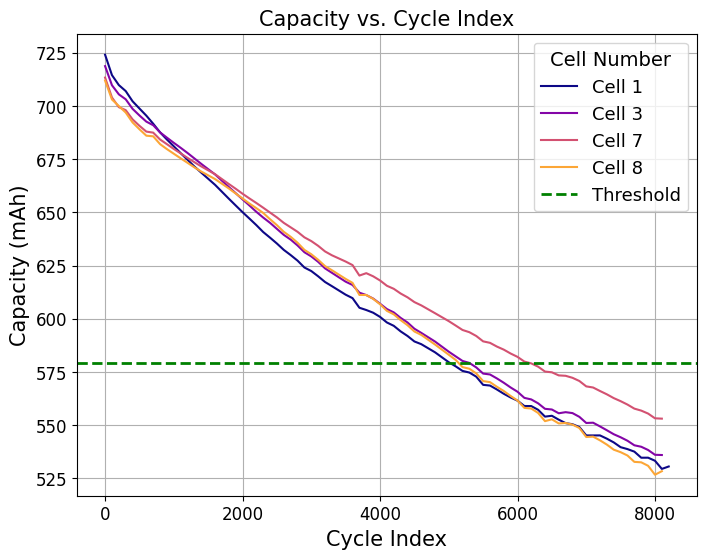

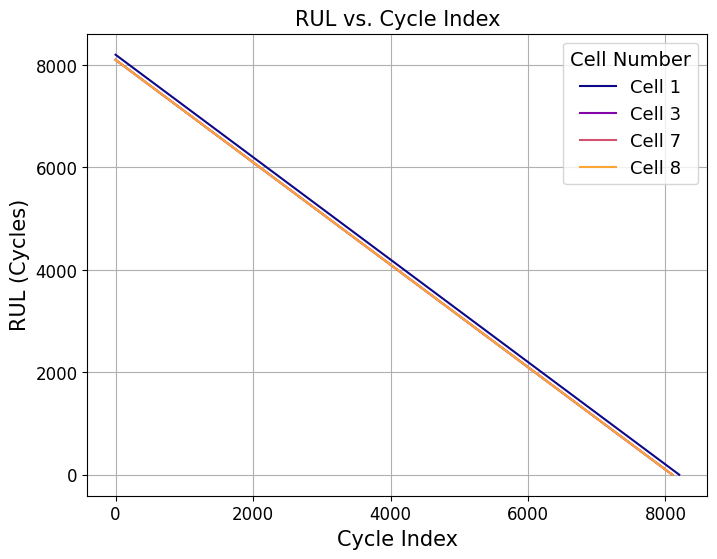

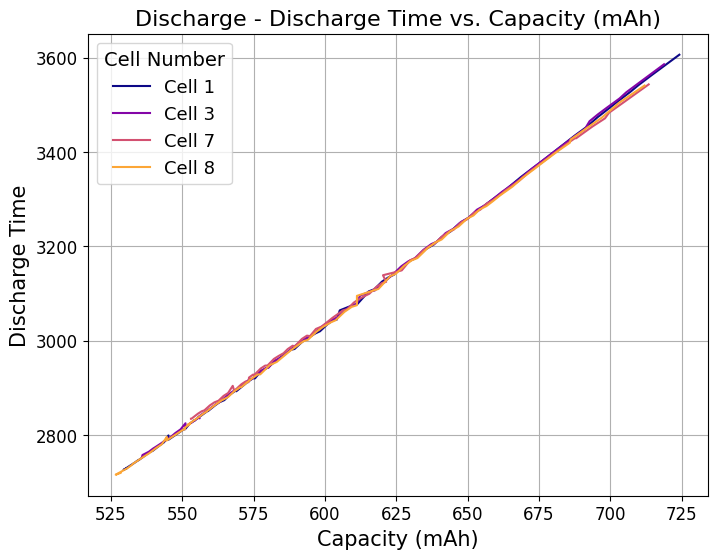

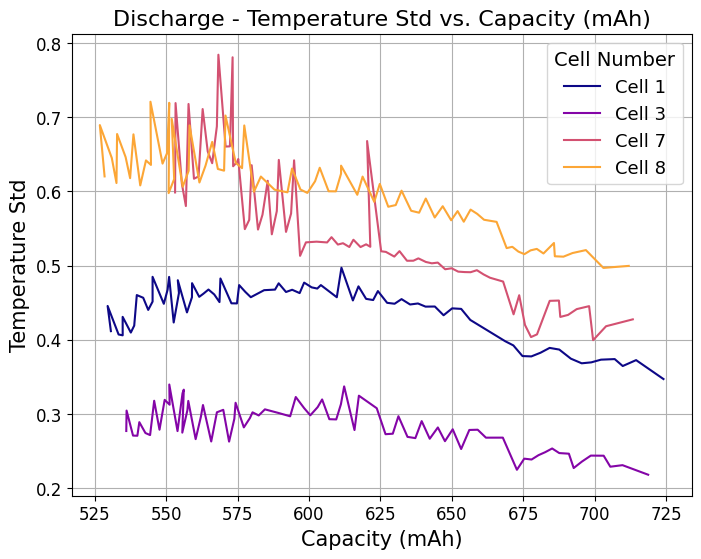

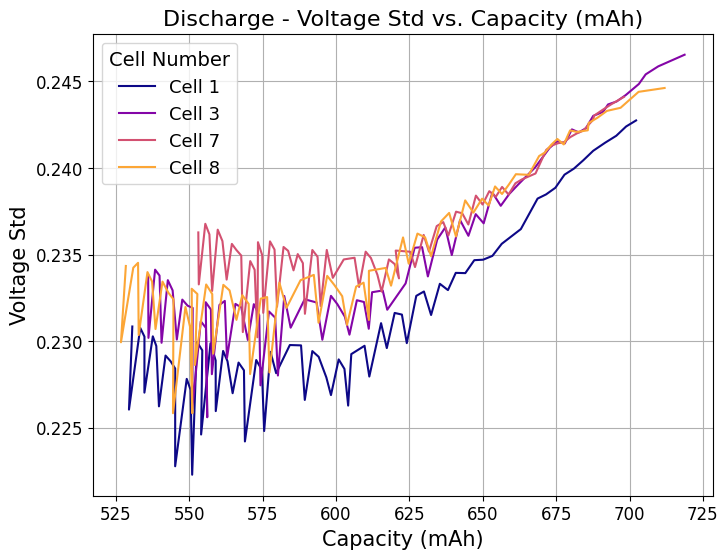

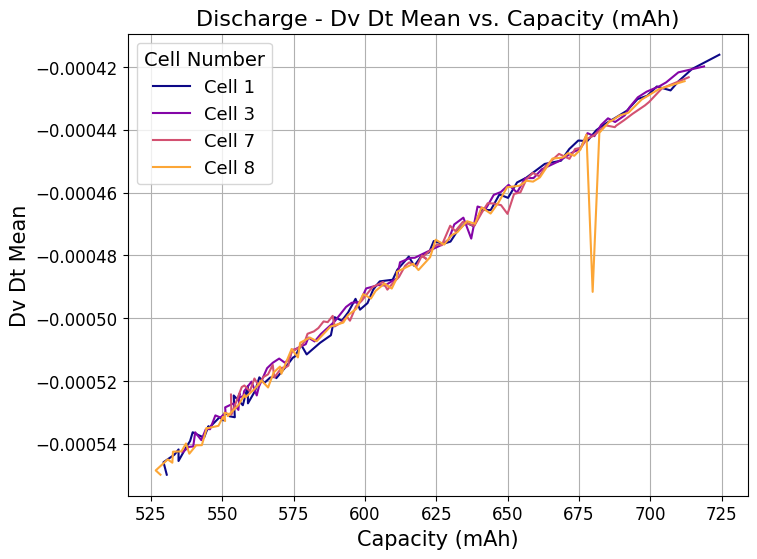

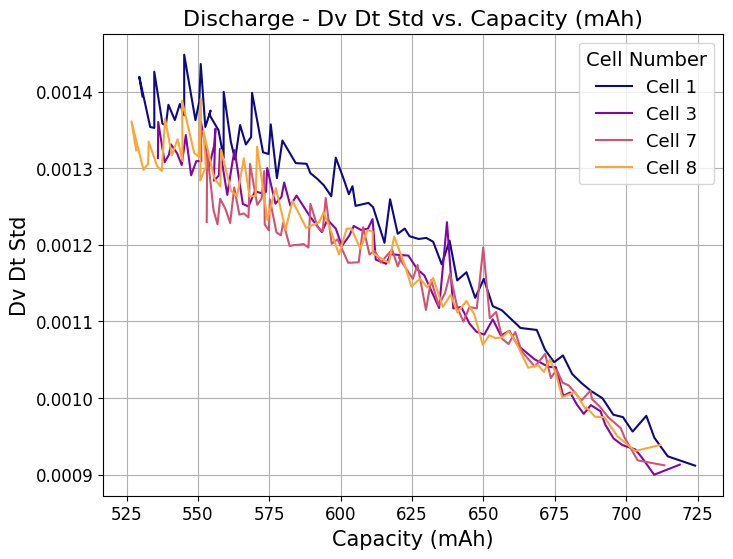

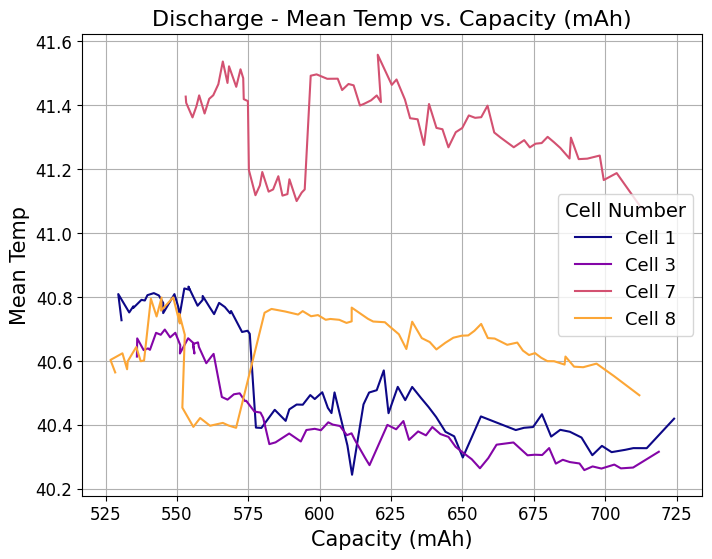

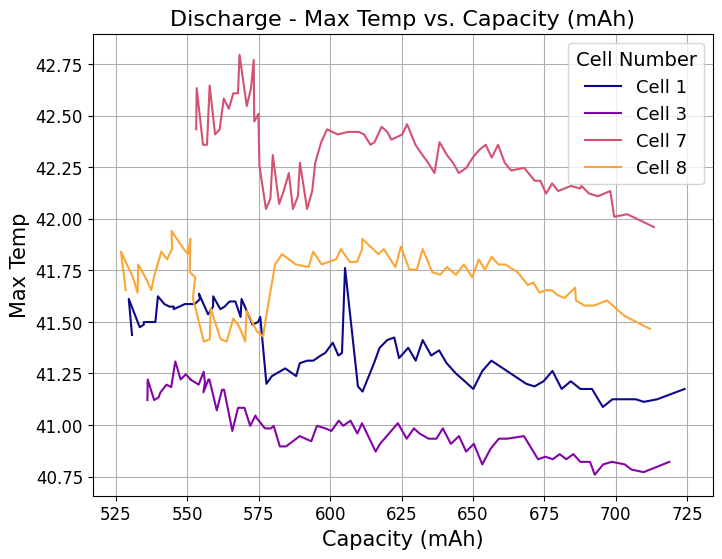

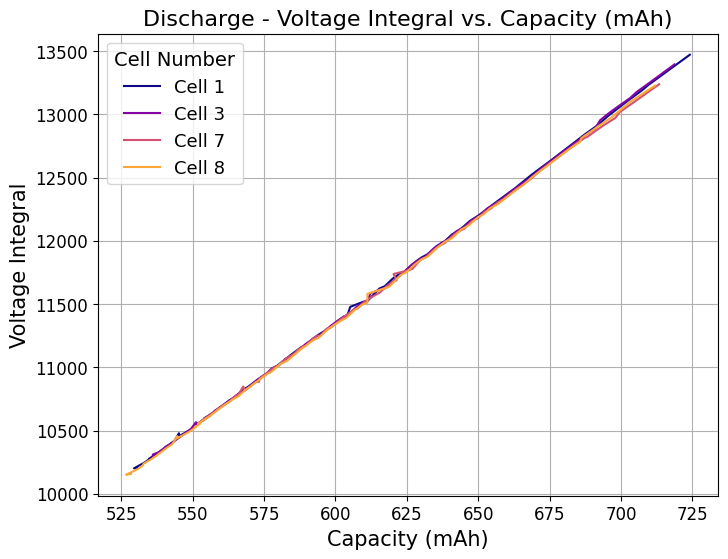

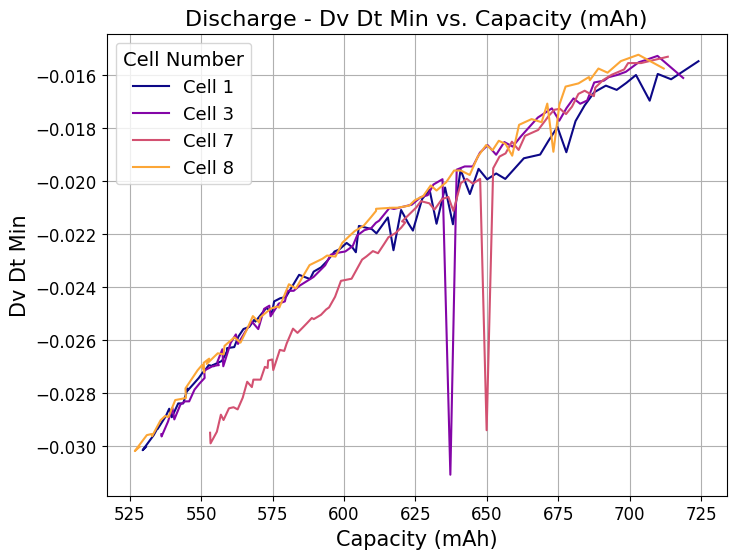

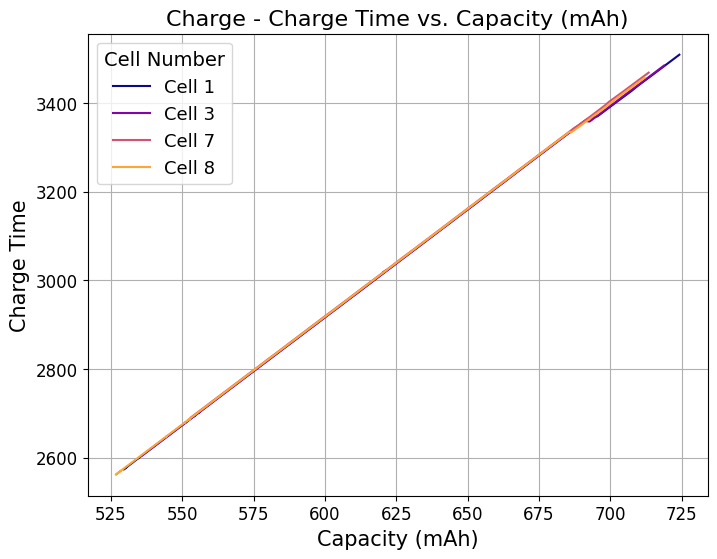

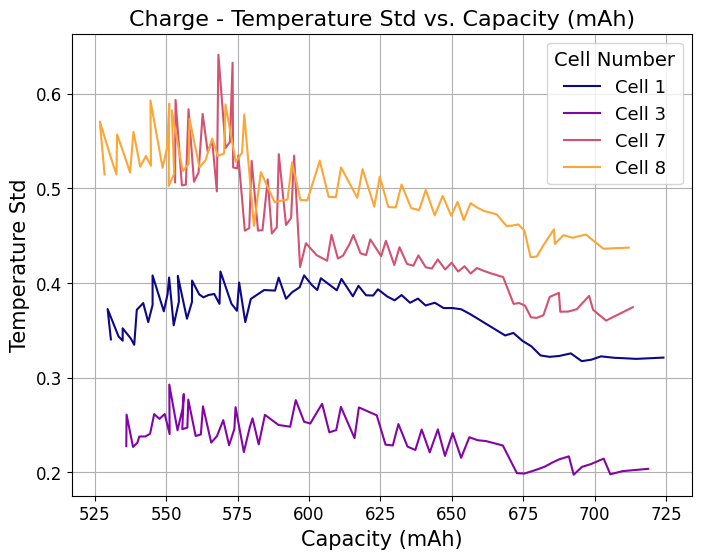

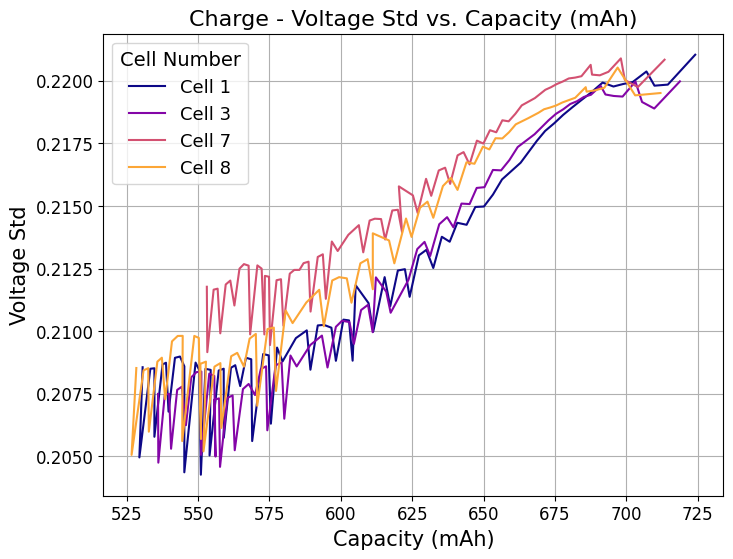

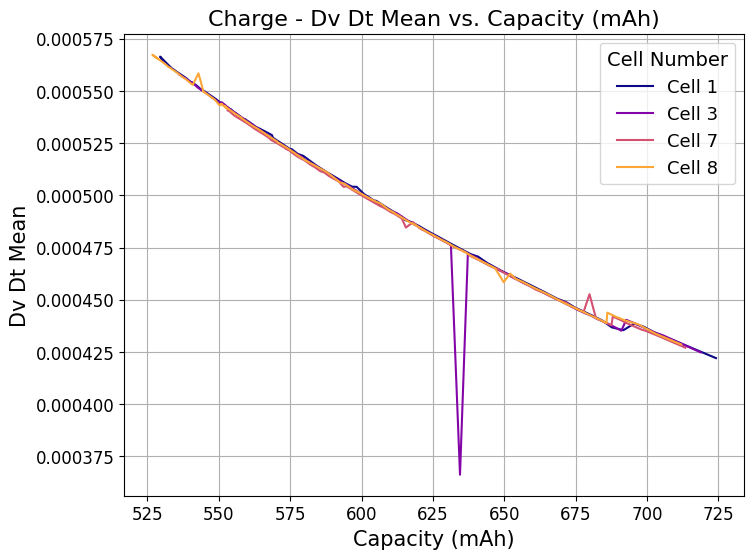

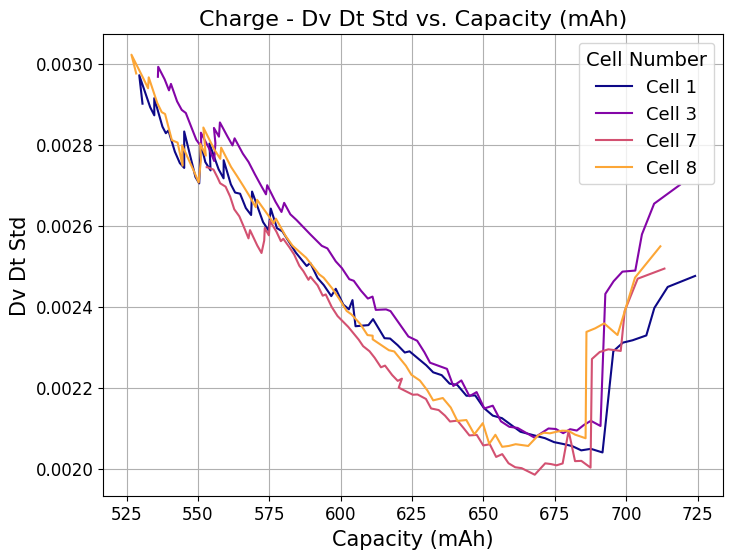

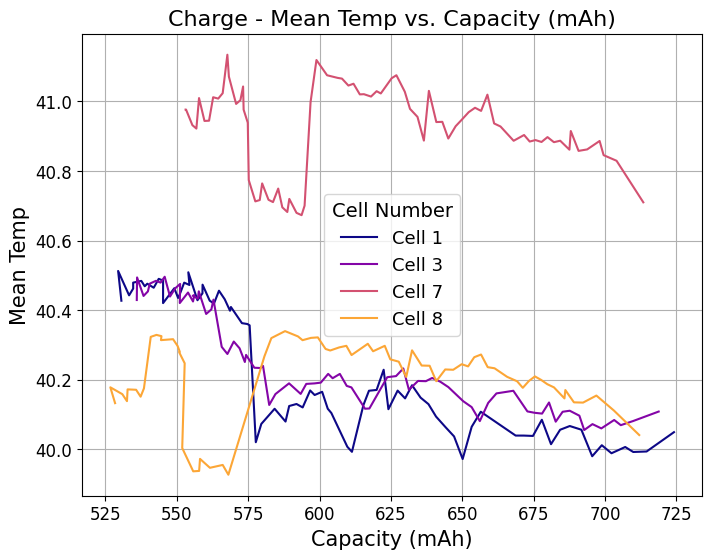

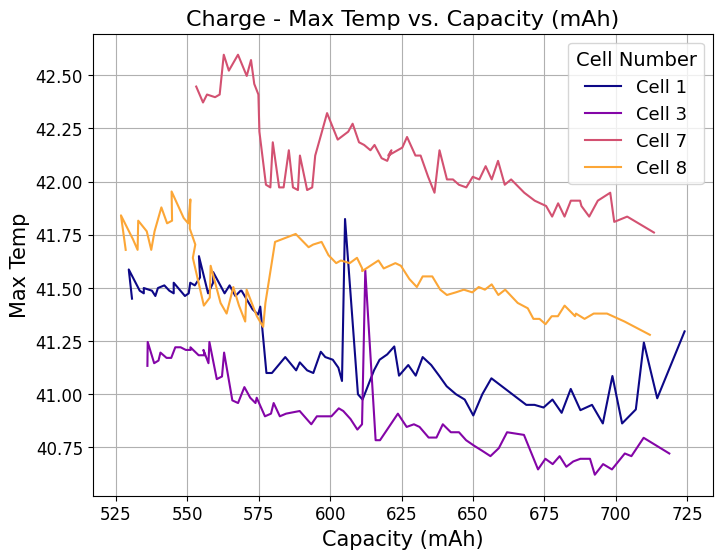

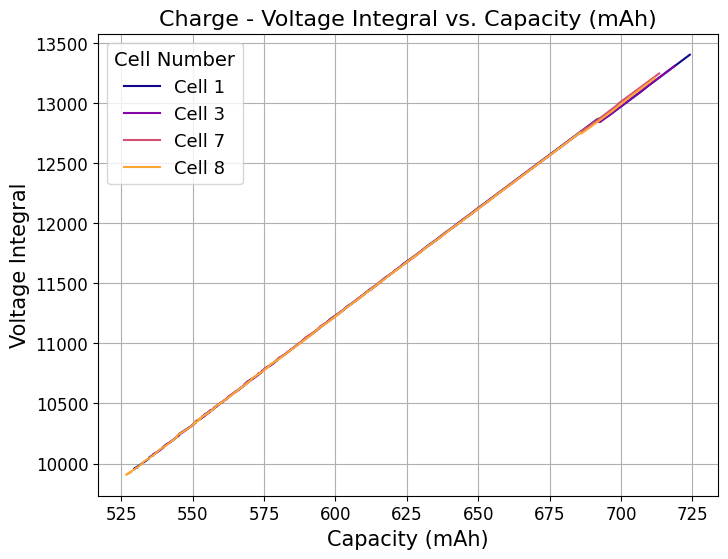

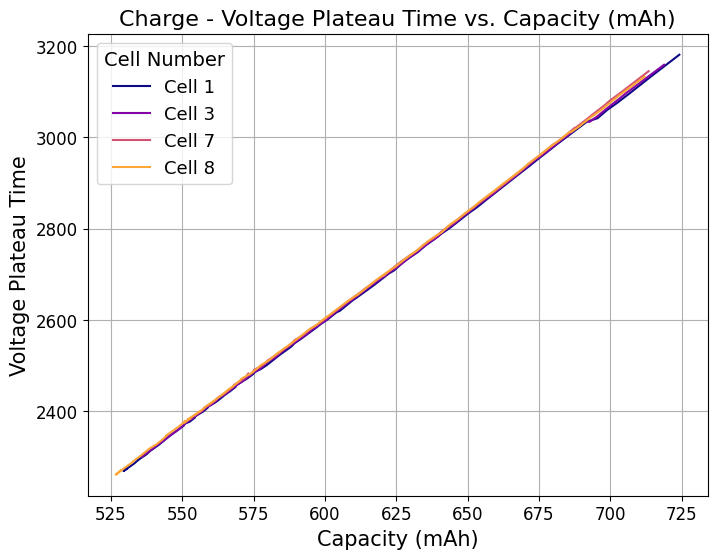

In [5]:
# Choose which x-axis to use for plotting HIs
x_axis = 'capacity' # 'cycle'  # or 'capacity'

# Plot capacity vs. cycle for all cells
plt.figure(figsize=(8, 6))
colors = plt.cm.plasma(np.linspace(0, 0.8, len(train_conditions)))
for i, C_path in enumerate(Capacity_list):
    plt.plot(Cycle_list[i], C_path, label=f'Cell {train_conditions[i]}', color=colors[i])

plt.axhline(C0*0.8, color="green", linestyle="--", linewidth=2, label="Threshold")
plt.xlabel("Cycle Index", fontsize=15)
plt.ylabel("Capacity (mAh)", fontsize=15)
plt.title("Capacity vs. Cycle Index", fontsize=15)
plt.legend(title="Cell Number", fontsize=13, title_fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

# Plot RUL vs. cycle
plt.figure(figsize=(8, 6))
for i, RUL_path in enumerate(RUL_list):
    plt.plot(Cycle_list[i], RUL_path, label=f'Cell {train_conditions[i]}', color=colors[i])

plt.xlabel("Cycle Index", fontsize=15)
plt.ylabel("RUL (Cycles)", fontsize=15)
plt.title("RUL vs. Cycle Index", fontsize=15)
plt.legend(title="Cell Number", fontsize=13, title_fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()    

# Plot Discharge HIs
for hi_name, hi_data_for_all_cells in agg_HIs_dch.items():
    plt.figure(figsize=(8, 6))
    
    for i, hi_path in enumerate(hi_data_for_all_cells):
        if i < len(Cycle_list):
            x_data = Cycle_list[i] if x_axis == 'cycle' else Capacity_list[i]
            y_data = hi_path

            # Remove outliers
            y_data_clean, mask = remove_outliers(y_data)
            x_data_clean = np.array(x_data)[mask]

            plt.plot(x_data_clean, y_data_clean, label=f'Cell {train_conditions[i]}', color=colors[i])
    
    xlabel = "Cycle Index" if x_axis == 'cycle' else "Capacity (mAh)"
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(hi_name.replace('_', ' ').title(), fontsize=15)
    plt.title(f"Discharge - {hi_name.replace('_', ' ').title()} vs. {xlabel}", fontsize=16)
    plt.legend(title="Cell Number", fontsize=13, title_fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.show()

# Plot Charge HIs
for hi_name, hi_data_for_all_cells in agg_HIs_ch.items():
    plt.figure(figsize=(8, 6))
    
    for i, hi_path in enumerate(hi_data_for_all_cells):
        if i < len(Cycle_list):
            x_data = Cycle_list[i] if x_axis == 'cycle' else Capacity_list[i]
            y_data = hi_path

            # Remove outliers
            y_data_clean, mask = remove_outliers(y_data)
            x_data_clean = np.array(x_data)[mask]

            plt.plot(x_data_clean, y_data_clean, label=f'Cell {train_conditions[i]}', color=colors[i])
    
    xlabel = "Cycle Index" if x_axis == 'cycle' else "Capacity (mAh)"
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(hi_name.replace('_', ' ').title(), fontsize=15)
    plt.title(f"Charge - {hi_name.replace('_', ' ').title()} vs. {xlabel}", fontsize=16)
    plt.legend(title="Cell Number", fontsize=13, title_fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.show()

## Pearson Corrolation Analysis

### For All Health Indicators

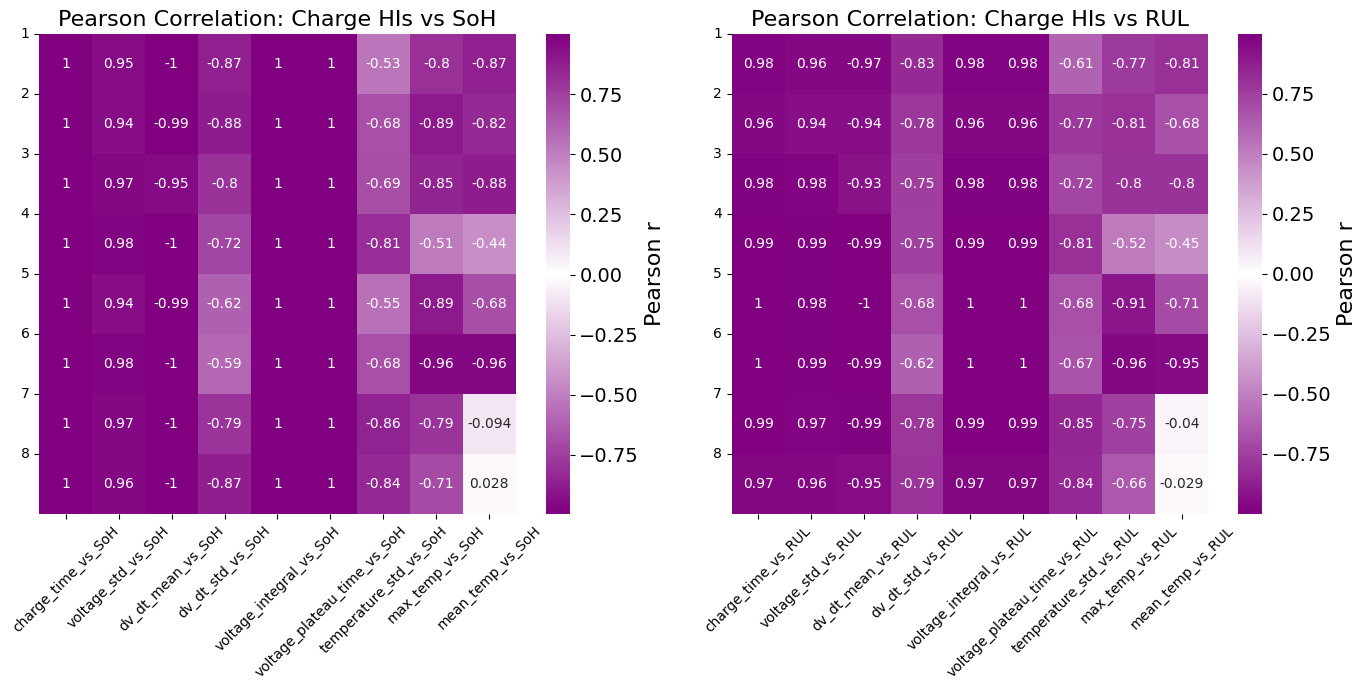

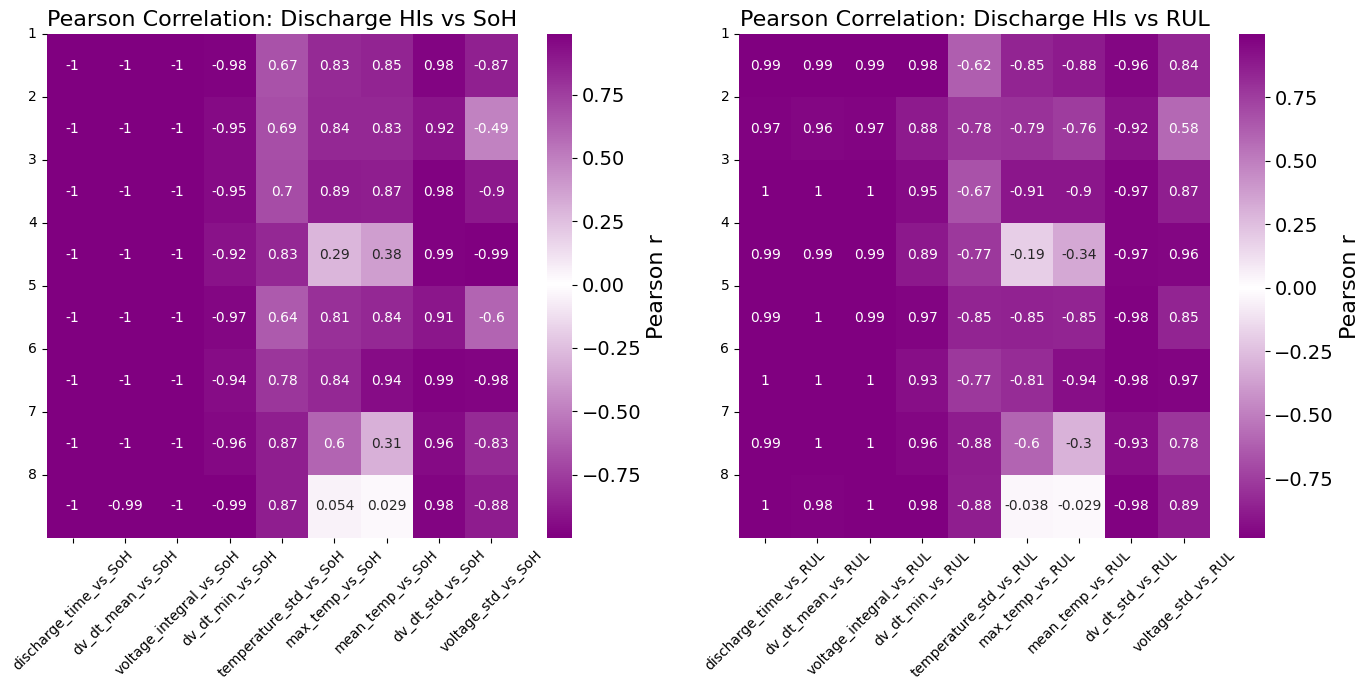

In [ ]:
selected_HIs_dch_list = ['discharge_time', 'dv_dt_mean', 'voltage_integral', 'dv_dt_min', 'temperature_std', 'max_temp', 'mean_temp', 'dv_dt_std', 'voltage_std']
selected_HIs_ch_list = ['charge_time', 'voltage_std', 'dv_dt_mean', 'dv_dt_std', 'voltage_integral', 'voltage_plateau_time', 'temperature_std', 'max_temp', 'mean_temp']

cmap = LinearSegmentedColormap.from_list(
    'purple_white_purple', ['purple', 'white', 'purple'])

def pearson_analysis_per_cell(cell_ids, data_dict, selected_HIs, C0, ch_dch='dch'):
    results_SoH = []
    results_RUL = []

    for cond in cell_ids:
        cell_data = data_dict[cond]

        # Target variables
        Capacity = np.array(cell_data[f'{ch_dch}_cap'])
        Cycles = np.array(cell_data['cycles'])
        RUL = compute_rul(abs(Capacity), Cycles, threshold=0.8 * C0)
        SoH = np.array(Capacity)/ C0

        result_SoH = {'Cell': cond}
        result_RUL = {'Cell': cond}

        for hi in selected_HIs:
            HI_values = np.array(cell_data[f'HIs_{ch_dch}'][hi])
            HI_values, mask = remove_outliers(HI_values)
            r_rul, _ = stats.pearsonr(HI_values, RUL[mask])
            r_soh, _ = stats.pearsonr(HI_values, SoH[mask])
            result_RUL[f'{hi}_vs_RUL'] = r_rul
            result_SoH[f'{hi}_vs_SoH'] = r_soh

        results_RUL.append(result_RUL)
        results_SoH.append(result_SoH)

    df_RUL = pd.DataFrame(results_RUL)
    df_SoH = pd.DataFrame(results_SoH)
    return df_RUL, df_SoH

df_RUL_ch, df_SoH_ch = pearson_analysis_per_cell(
    cell_ids=[1,2,3,4,5,6,7,8],
    data_dict=data_dict,
    selected_HIs=selected_HIs_ch_list,
    C0=C0,
    ch_dch='ch')

df_RUL_dch, df_SoH_dch = pearson_analysis_per_cell(
    cell_ids=[1,2,3,4,5,6,7,8],
    data_dict=data_dict,
    selected_HIs=selected_HIs_dch_list,
    C0=C0,
    ch_dch='dch')

df_SoH_plot = df_SoH_ch.drop(columns=['Cell'])
df_RUL_plot = df_RUL_ch.drop(columns=['Cell'])

# Plot Heatmaps
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
ax = sns.heatmap(df_SoH_plot, annot=True, center=0, cmap=cmap, cbar_kws={"label": "Pearson r"})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)        
cbar.set_label("Pearson r", fontsize=16)  
plt.title("Pearson Correlation: Charge HIs vs SoH").set_fontsize(16)
plt.yticks(ticks=np.arange(len(df_SoH_plot)), labels=df_SoH_ch['Cell'], rotation=0)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
ax = sns.heatmap(df_RUL_plot, annot=True, center=0, cmap=cmap, cbar_kws={"label": "Pearson r"})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)        
cbar.set_label("Pearson r", fontsize=16)  
plt.title("Pearson Correlation: Charge HIs vs RUL").set_fontsize(16)
plt.yticks(ticks=np.arange(len(df_RUL_plot)), labels=df_RUL_ch['Cell'], rotation=0)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Drop 'Cell' column for heatmap and histogram plotting
df_SoH_plot = df_SoH_dch.drop(columns=['Cell'])
df_RUL_plot = df_RUL_dch.drop(columns=['Cell'])

# Plot Heatmaps
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
ax = sns.heatmap(df_SoH_plot, annot=True, center=0, cmap=cmap, cbar_kws={"label": "Pearson r"})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)        
cbar.set_label("Pearson r", fontsize=16)  
plt.title("Pearson Correlation: Discharge HIs vs SoH").set_fontsize(16)
plt.yticks(ticks=np.arange(len(df_SoH_plot)), labels=df_SoH_dch['Cell'], rotation=0)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
ax = sns.heatmap(df_RUL_plot, annot=True, center=0, cmap=cmap, cbar_kws={"label": "Pearson r"})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)        
cbar.set_label("Pearson r", fontsize=16)  
plt.title("Pearson Correlation: Discharge HIs vs RUL").set_fontsize(16)
plt.yticks(ticks=np.arange(len(df_RUL_plot)), labels=df_RUL_dch['Cell'], rotation=0)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



### For Selected Health Indicators

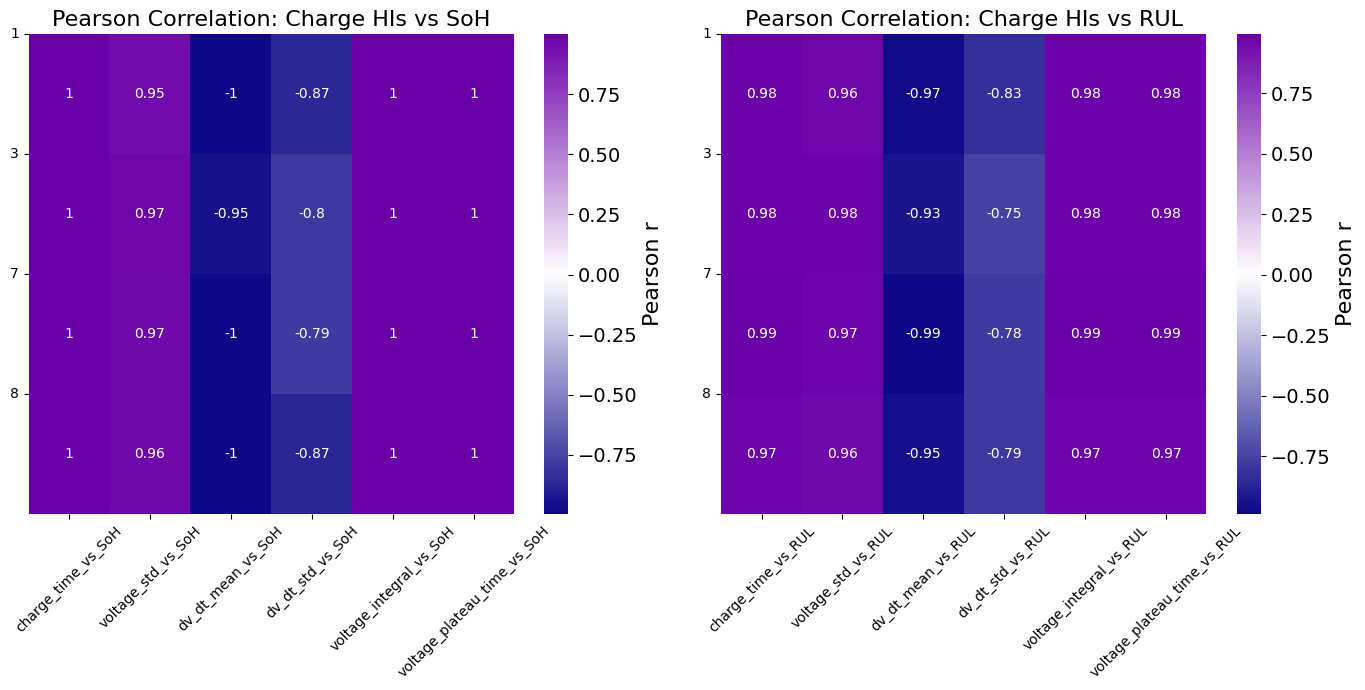

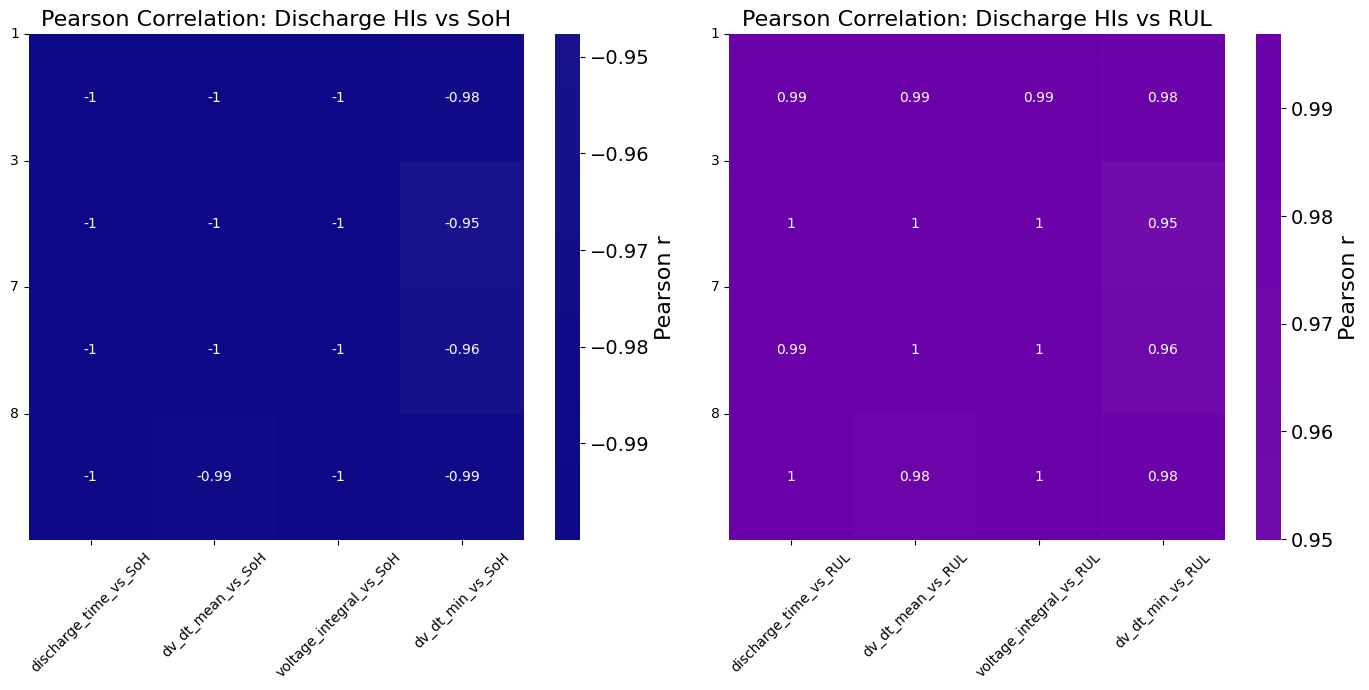

In [ ]:
selected_HIs_dch_list = ['discharge_time', 'dv_dt_mean', 'voltage_integral', 'dv_dt_min']
selected_HIs_ch_list = ['charge_time', 'voltage_std', 'dv_dt_mean', 'dv_dt_std', 'voltage_integral', 'voltage_plateau_time']

colors = plt.cm.plasma(np.linspace(0, 0.8, 5))

'''cmap = LinearSegmentedColormap.from_list(
    'purple_white_purple', ['red', 'white', 'purple'])'''

cmap = LinearSegmentedColormap.from_list(
    'purple_white_purple', [colors[0], 'white', colors[1]])

def pearson_analysis_per_cell(cell_ids, data_dict, selected_HIs, C0, ch_dch='dch'):
    results_SoH = []
    results_RUL = []

    for cond in cell_ids:
        cell_data = data_dict[cond]

        # Target variables
        Capacity = np.array(cell_data[f'{ch_dch}_cap'])
        Cycles = np.array(cell_data['cycles'])
        RUL = compute_rul(abs(Capacity), Cycles, threshold=0.8 * C0)
        SoH = np.array(Capacity)/ C0

        result_SoH = {'Cell': cond}
        result_RUL = {'Cell': cond}

        for hi in selected_HIs:
            HI_values = np.array(cell_data[f'HIs_{ch_dch}'][hi])
            HI_values, mask = remove_outliers(HI_values)
            r_rul, _ = stats.pearsonr(HI_values, RUL[mask])
            r_soh, _ = stats.pearsonr(HI_values, SoH[mask])
            result_RUL[f'{hi}_vs_RUL'] = r_rul
            result_SoH[f'{hi}_vs_SoH'] = r_soh

        results_RUL.append(result_RUL)
        results_SoH.append(result_SoH)

    df_RUL = pd.DataFrame(results_RUL)
    df_SoH = pd.DataFrame(results_SoH)
    return df_RUL, df_SoH

df_RUL_ch, df_SoH_ch = pearson_analysis_per_cell(
    cell_ids=[1,3,7,8],
    data_dict=data_dict,
    selected_HIs=selected_HIs_ch_list,
    C0=C0,
    ch_dch='ch')

df_RUL_dch, df_SoH_dch = pearson_analysis_per_cell(
    cell_ids=[1,3,7,8],
    data_dict=data_dict,
    selected_HIs=selected_HIs_dch_list,
    C0=C0,
    ch_dch='dch')

df_SoH_plot = df_SoH_ch.drop(columns=['Cell'])
df_RUL_plot = df_RUL_ch.drop(columns=['Cell'])

# Plot Heatmaps
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
ax = sns.heatmap(df_SoH_plot, annot=True, center=0, cmap=cmap, cbar_kws={"label": "Pearson r"})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)        
cbar.set_label("Pearson r", fontsize=16)  
plt.title("Pearson Correlation: Charge HIs vs SoH").set_fontsize(16)
plt.yticks(ticks=np.arange(len(df_SoH_plot)), labels=df_SoH_ch['Cell'], rotation=0)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
ax = sns.heatmap(df_RUL_plot, annot=True, center=0, cmap=cmap, cbar_kws={"label": "Pearson r"})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)        
cbar.set_label("Pearson r", fontsize=16)  
plt.title("Pearson Correlation: Charge HIs vs RUL").set_fontsize(16)
plt.yticks(ticks=np.arange(len(df_RUL_plot)), labels=df_RUL_ch['Cell'], rotation=0)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Drop 'Cell' column for heatmap and histogram plotting
df_SoH_plot = df_SoH_dch.drop(columns=['Cell'])
df_RUL_plot = df_RUL_dch.drop(columns=['Cell'])

# Plot Heatmaps
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
ax = sns.heatmap(df_SoH_plot, annot=True, center=0, cmap=cmap, cbar_kws={"label": "Pearson r"})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)        
cbar.set_label("Pearson r", fontsize=16)  
plt.title("Pearson Correlation: Discharge HIs vs SoH").set_fontsize(16)
plt.yticks(ticks=np.arange(len(df_SoH_plot)), labels=df_SoH_dch['Cell'], rotation=0)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
ax = sns.heatmap(df_RUL_plot, annot=True, center=0, cmap=cmap, cbar_kws={"label": "Pearson r"})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)        
cbar.set_label("Pearson r", fontsize=16)  
plt.title("Pearson Correlation: Discharge HIs vs RUL").set_fontsize(16)
plt.yticks(ticks=np.arange(len(df_RUL_plot)), labels=df_RUL_dch['Cell'], rotation=0)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

